In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import cv2
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from collections import deque
from sklearn.metrics import classification_report,plot_confusion_matrix, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.cluster import KMeans

## 1. Load Dataset

In [2]:
path = "./Video_Dataset"
directories = os.listdir(path)
print(directories)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
files = []
temp_target = []
for sub_dir in directories:
    temp_actor = os.listdir(path+"/"+sub_dir)
    for ele in temp_actor:
        temp = ele.split("-")
        temp_target.append(int(temp[2]))
        files.append(path+"/"+sub_dir+"/"+ele)

# 2. EDA

<AxesSubplot:ylabel='count'>

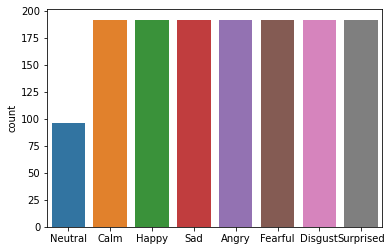

In [4]:
emotion = { 1: "Neutral", 2: "Calm", 3: "Happy", 4: "Sad", 5: "Angry", 6: "Fearful",7: "Disgust",8:"Surprised"}
emotions = []
for ele in temp_target:
    emotions.append(emotion[ele])
sns.countplot(emotions)

# 3. Data Pre-processing

In [5]:
dataset = []
target = []
for i in range(len(files)):
    cap = cv2.VideoCapture(files[i])
    frameRate = cap.get(5)
    while(cap.isOpened()):
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret == False:
            break
        if (frameId % math.floor(frameRate) == 0):
            frame = cv2.resize(frame, (224, 224))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            dataset.append(frame)
            target.append(temp_target[i])
    cap.release()

In [6]:
dataset = np.array(dataset)
target_predefined = target
target = OneHotEncoder().fit_transform(np.array(target).reshape(-1,1)).toarray()

# 3.1 Data Splitting

In [8]:
data_train, data_test, target_train, target_test = train_test_split(dataset, target,test_size = 0.2, random_state = 123, shuffle = True)
data_train, data_val, target_train, target_val = train_test_split(data_train, target_train, test_size = 0.2)

# 4 Model Fitting and Result Evaluation

## 4.1 RNN Model

In [9]:
baseline = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
head = baseline.output
head = AveragePooling2D(pool_size=(5, 5))(head)
head = Flatten(name="flatten")(head)
head = Dense(256, activation="relu")(head)
head = Dropout(0.3)(head)
head = Dense(128, activation="relu")(head)
head = Dropout(0.3)(head)
head = Dense(64, activation="relu")(head)
head = Dropout(0.3)(head)
head = Dense(32, activation="relu")(head)
head = Dropout(0.3)(head)
head = Dense(8, activation="softmax")(head)
model = Model(inputs = baseline.input, outputs = head)
for layer in baseline.layers:
    layer.trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

For adam optimizer:


Epoch 1/20
40/40 [==============================] - 228s 6s/step - loss: 2.1839 - accuracy: 0.1376 - val_loss: 2.0677 - val_accuracy: 0.1230
Epoch 2/20
40/40 [==============================] - 205s 5s/step - loss: 2.0924 - accuracy: 0.1411 - val_loss: 2.0499 - val_accuracy: 0.2131
Epoch 3/20
40/40 [==============================] - 212s 5s/step - loss: 2.0569 - accuracy: 0.1678 - val_loss: 2.0252 - val_accuracy: 0.2029
Epoch 4/20
40/40 [==============================] - 214s 5s/step - loss: 2.0389 - accuracy: 0.1703 - val_loss: 2.0033 - val_accuracy: 0.1988
Epoch 5/20
40/40 [==============================] - 217s 5s/step - loss: 1.9985 - accuracy: 0.2057 - val_loss: 1.9238 - val_accuracy: 0.2541
Epoch 6/20
40/40 [==============================] - 213s 5s/step - loss: 1.9432 - accuracy: 0.2257 - val_loss: 1.8798 - val_accuracy: 0.2254
Epoch 7/20
40/40 [==============================] - 215s 5s/step - loss: 1.9081 - accuracy: 0.2413 - val_loss: 1.7788 - val_accuracy

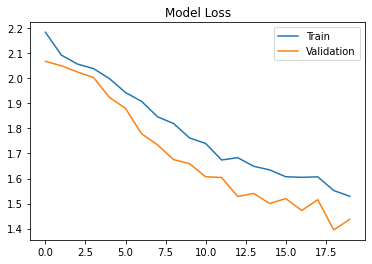

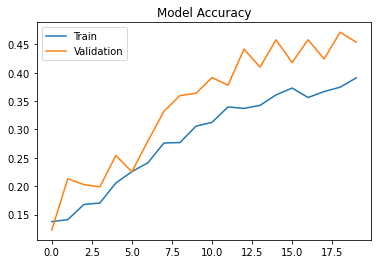

For rmsprop optimizer:


Epoch 1/20
40/40 [==============================] - 235s 6s/step - loss: 1.5595 - accuracy: 0.3940 - val_loss: 1.3573 - val_accuracy: 0.4867
Epoch 2/20
40/40 [==============================] - 231s 6s/step - loss: 1.5082 - accuracy: 0.4078 - val_loss: 1.3742 - val_accuracy: 0.4621
Epoch 3/20
40/40 [==============================] - 236s 6s/step - loss: 1.4800 - accuracy: 0.4134 - val_loss: 1.3926 - val_accuracy: 0.4652
Epoch 4/20
40/40 [==============================] - 232s 6s/step - loss: 1.4800 - accuracy: 0.4155 - val_loss: 1.3840 - val_accuracy: 0.4590
Epoch 5/20
40/40 [==============================] - 234s 6s/step - loss: 1.4565 - accuracy: 0.4206 - val_loss: 1.3112 - val_accuracy: 0.5061
Epoch 6/20
40/40 [==============================] - 245s 6s/step - loss: 1.4447 - accuracy: 0.4278 - val_loss: 1.3841 - val_accuracy: 0.4631
Epoch 7/20
40/40 [==============================] - 260s 7s/step - loss: 1.4368 - accuracy: 0.4203 - val_loss: 1.3011 - val_accur

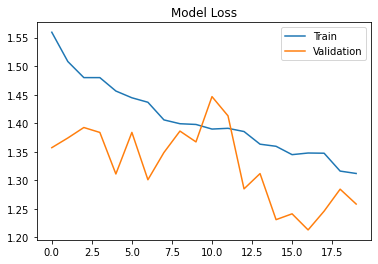

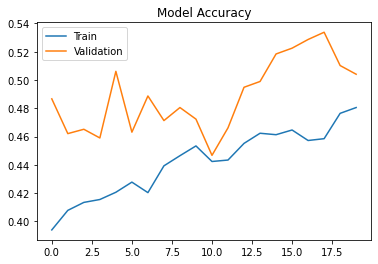

For sgd optimizer:


Epoch 1/20
40/40 [==============================] - 320s 8s/step - loss: 1.3166 - accuracy: 0.4662 - val_loss: 1.2882 - val_accuracy: 0.5061
Epoch 2/20
40/40 [==============================] - 306s 8s/step - loss: 1.3163 - accuracy: 0.4652 - val_loss: 1.2418 - val_accuracy: 0.5061
Epoch 3/20
40/40 [==============================] - 305s 8s/step - loss: 1.3074 - accuracy: 0.4685 - val_loss: 1.2185 - val_accuracy: 0.5236
Epoch 4/20
40/40 [==============================] - 307s 8s/step - loss: 1.2905 - accuracy: 0.4839 - val_loss: 1.2452 - val_accuracy: 0.5164
Epoch 5/20
40/40 [==============================] - 305s 8s/step - loss: 1.2985 - accuracy: 0.4872 - val_loss: 1.2926 - val_accuracy: 0.5082
Epoch 6/20
40/40 [==============================] - 304s 8s/step - loss: 1.3497 - accuracy: 0.4639 - val_loss: 1.3654 - val_accuracy: 0.4713
Epoch 7/20
40/40 [==============================] - 303s 8s/step - loss: 1.2934 - accuracy: 0.4693 - val_loss: 1.2511 - val_accuracy:

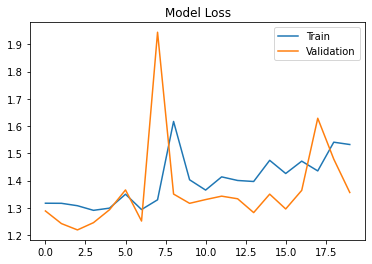

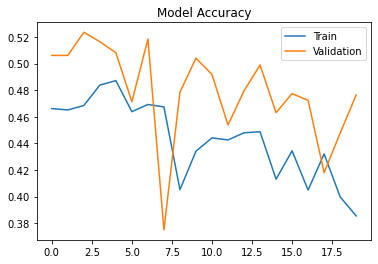

Best optimizer for our model is rmsprop with accuracy of 0.4655737578868866


In [11]:
optimizers = ['adam', 'rmsprop', 'sgd']
best_optim = ''
best_acc = 0
best_train_acc = 0
for optim in optimizers:
    print("For "+optim+" optimizer:\n\n")
    model.compile(optimizer = optim,loss = 'categorical_crossentropy', metrics = ['accuracy'])
    results = model.fit(data_train, target_train, epochs = 20, batch_size = 100, validation_data = (data_val, target_val), shuffle = False)
    ls, acc = model.evaluate(data_test,target_test)
    print("\n Model loss is: "+str(ls)+ " and model accuracy is: "+str(acc))
    results_dict = results.history
    if best_acc < acc:
        best_optim = optim
        best_acc = acc
        best_train_acc = results_dict['accuracy'][-1]
    train_loss_list = results_dict['loss']
    train_acc_list = results_dict['accuracy']
    val_loss_list = results_dict['val_loss']
    val_acc_list = results_dict['val_accuracy']
    plt.plot(train_loss_list)
    plt.plot(val_loss_list)
    plt.legend(['Train','Validation'])
    plt.title("Model Loss")
    plt.show()
    plt.plot(train_acc_list)
    plt.plot(val_acc_list)
    plt.legend(['Train','Validation'])
    plt.title("Model Accuracy")
    plt.show()
print('\033[1m'+"Best optimizer for our model is "+best_optim+" with accuracy of "+str(best_acc)+'\033[0m')

In [7]:
acc_train = []
acc_test = []
acc_train.append(best_train_acc)
acc_test.append(best_acc)

In [14]:
train_aug = ImageDataGenerator(rotation_range=30, zoom_range=0.15, horizontal_flip=True, fill_mode="nearest")
test_aug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
train_aug.mean = mean
test_aug.mean = mean

In [15]:
# Using the best model for output predictions on unseen test data
model.compile(optimizer = best_optim,loss = 'categorical_crossentropy', metrics = ['accuracy'])
dummy = model.fit(x=train_aug.flow(data_train, target_train, batch_size=32), validation_data=test_aug.flow(data_test, target_test), epochs= 20)

Epoch 1/20
122/122 [==============================] - 337s 3s/step - loss: 1.8926 - accuracy: 0.2759 - val_loss: 1.5320 - val_accuracy: 0.4230
Epoch 2/20
122/122 [==============================] - 337s 3s/step - loss: 1.7980 - accuracy: 0.3099 - val_loss: 1.5425 - val_accuracy: 0.4197
Epoch 3/20
122/122 [==============================] - 337s 3s/step - loss: 1.7631 - accuracy: 0.3197 - val_loss: 1.5034 - val_accuracy: 0.4123
Epoch 4/20
122/122 [==============================] - 339s 3s/step - loss: 1.7358 - accuracy: 0.3286 - val_loss: 1.4839 - val_accuracy: 0.4369
Epoch 5/20
122/122 [==============================] - 337s 3s/step - loss: 1.7123 - accuracy: 0.3335 - val_loss: 1.5340 - val_accuracy: 0.4041
Epoch 6/20
122/122 [==============================] - 341s 3s/step - loss: 1.7245 - accuracy: 0.3340 - val_loss: 1.4575 - val_accuracy: 0.4393
Epoch 7/20
122/122 [==============================] - 338s 3s/step - loss: 1.7094 - accuracy: 0.3427 - val_loss: 1.4484 - val_accuracy: 0.4689

### 4.1.1 Output Video Reconstruction

In [66]:
# Implementing rolling prediction averaging
dq = deque(maxlen = 128)
cap = cv2.VideoCapture(files[324])
i = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    disp = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype("float32")
    frame -= mean
    prediction = model.predict(np.expand_dims(frame, axis = 0))[0]
    dq.append(prediction)
    result = np.array(dq).mean(axis = 0)
    ind = np.argmax(result)
    emo = emotion[ind]
    string = "Emotion: " + str(emo)
    cv2.putText(disp, string, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,1.25, (0, 255, 0), 5)
    i += 1
    cv2.imwrite('./Video_Output/temp/Frame'+str(i)+'.jpg', disp)
    cv2.imshow("Output", disp)
    key = cv2.waitKey(1)
cap.release()

In [68]:
temp_path = './Video_Output/temp'
image_frames = os.listdir(temp_path)
fcc = cv2.VideoWriter_fourcc(*'mp4v') 
writer = None
for image in image_frames:
    frame = cv2.imread(temp_path + '/' + image)
    if writer is None:
        height,width,layers = frame.shape
        writer = cv2.VideoWriter('./Video_Output/result.avi',fcc,1,(width,height))
    writer.write(frame)
writer.release()

In [8]:
# dataset = dataset.to_numpy()
samples, nx, ny, nz = dataset.shape
dataset = dataset.reshape((samples,nx*ny*nz))
target_predefined = np.array(target_predefined)
data1_train, data1_test, target1_train, target1_test = train_test_split(dataset, target_predefined,test_size = 0.2, random_state = 123, shuffle = True)

In [9]:
print(data1_train.shape)
print(target1_train.shape)

(4880, 150528)
(4880,)


## 4.2 Gaussian Naive Bayes Classifier

Test Accuracy  0.17131147540983607
Train Accuracy  0.20061475409836066
              precision    recall  f1-score   support

           1       0.10      0.95      0.18        73
           2       0.36      0.27      0.31       152
           3       0.23      0.06      0.09       163
           4       0.22      0.16      0.18       165
           5       0.12      0.02      0.04       167
           6       0.27      0.21      0.23       165
           7       0.51      0.10      0.17       186
           8       0.18      0.05      0.07       149

    accuracy                           0.17      1220
   macro avg       0.25      0.23      0.16      1220
weighted avg       0.26      0.17      0.16      1220



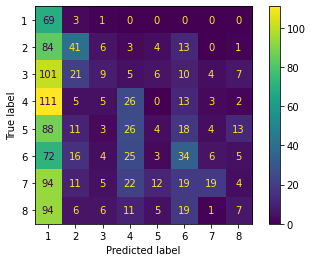

In [10]:
bayes = GNB().fit(data1_train,target1_train)
predictionTest = bayes.predict(data1_test)
predictionTrain = bayes.predict(data1_train)
print("Test Accuracy ",accuracy_score(target1_test,predictionTest))
print("Train Accuracy ",accuracy_score(target1_train,predictionTrain))
print(classification_report(target1_test,predictionTest))
plot_confusion_matrix(bayes,data1_test,target1_test)
acc_train.append(accuracy_score(target1_train,predictionTrain))
acc_test.append(accuracy_score(target1_test,predictionTest))

## 4.3 Decision Tree Classifier

Test Accuracy  0.3909836065573771
Train Accuracy  1.0
              precision    recall  f1-score   support

           1       0.53      0.59      0.56        73
           2       0.47      0.48      0.47       152
           3       0.46      0.43      0.44       163
           4       0.30      0.31      0.30       165
           5       0.32      0.35      0.34       167
           6       0.38      0.38      0.38       165
           7       0.44      0.35      0.39       186
           8       0.34      0.36      0.35       149

    accuracy                           0.39      1220
   macro avg       0.40      0.41      0.40      1220
weighted avg       0.39      0.39      0.39      1220



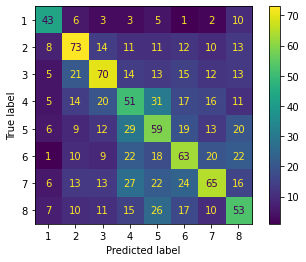

In [11]:
DTC = tree.DecisionTreeClassifier(criterion = 'gini').fit(data1_train, target1_train)
predictionTest = DTC.predict(data1_test)
predictionTrain = DTC.predict(data1_train)
print("Test Accuracy ",accuracy_score(target1_test,predictionTest))
print("Train Accuracy ",accuracy_score(target1_train,predictionTrain))
print(classification_report(target1_test,predictionTest))
plot_confusion_matrix(DTC,data1_test,target1_test)
acc_train.append(accuracy_score(target1_train,predictionTrain))
acc_test.append(accuracy_score(target1_test,predictionTest))

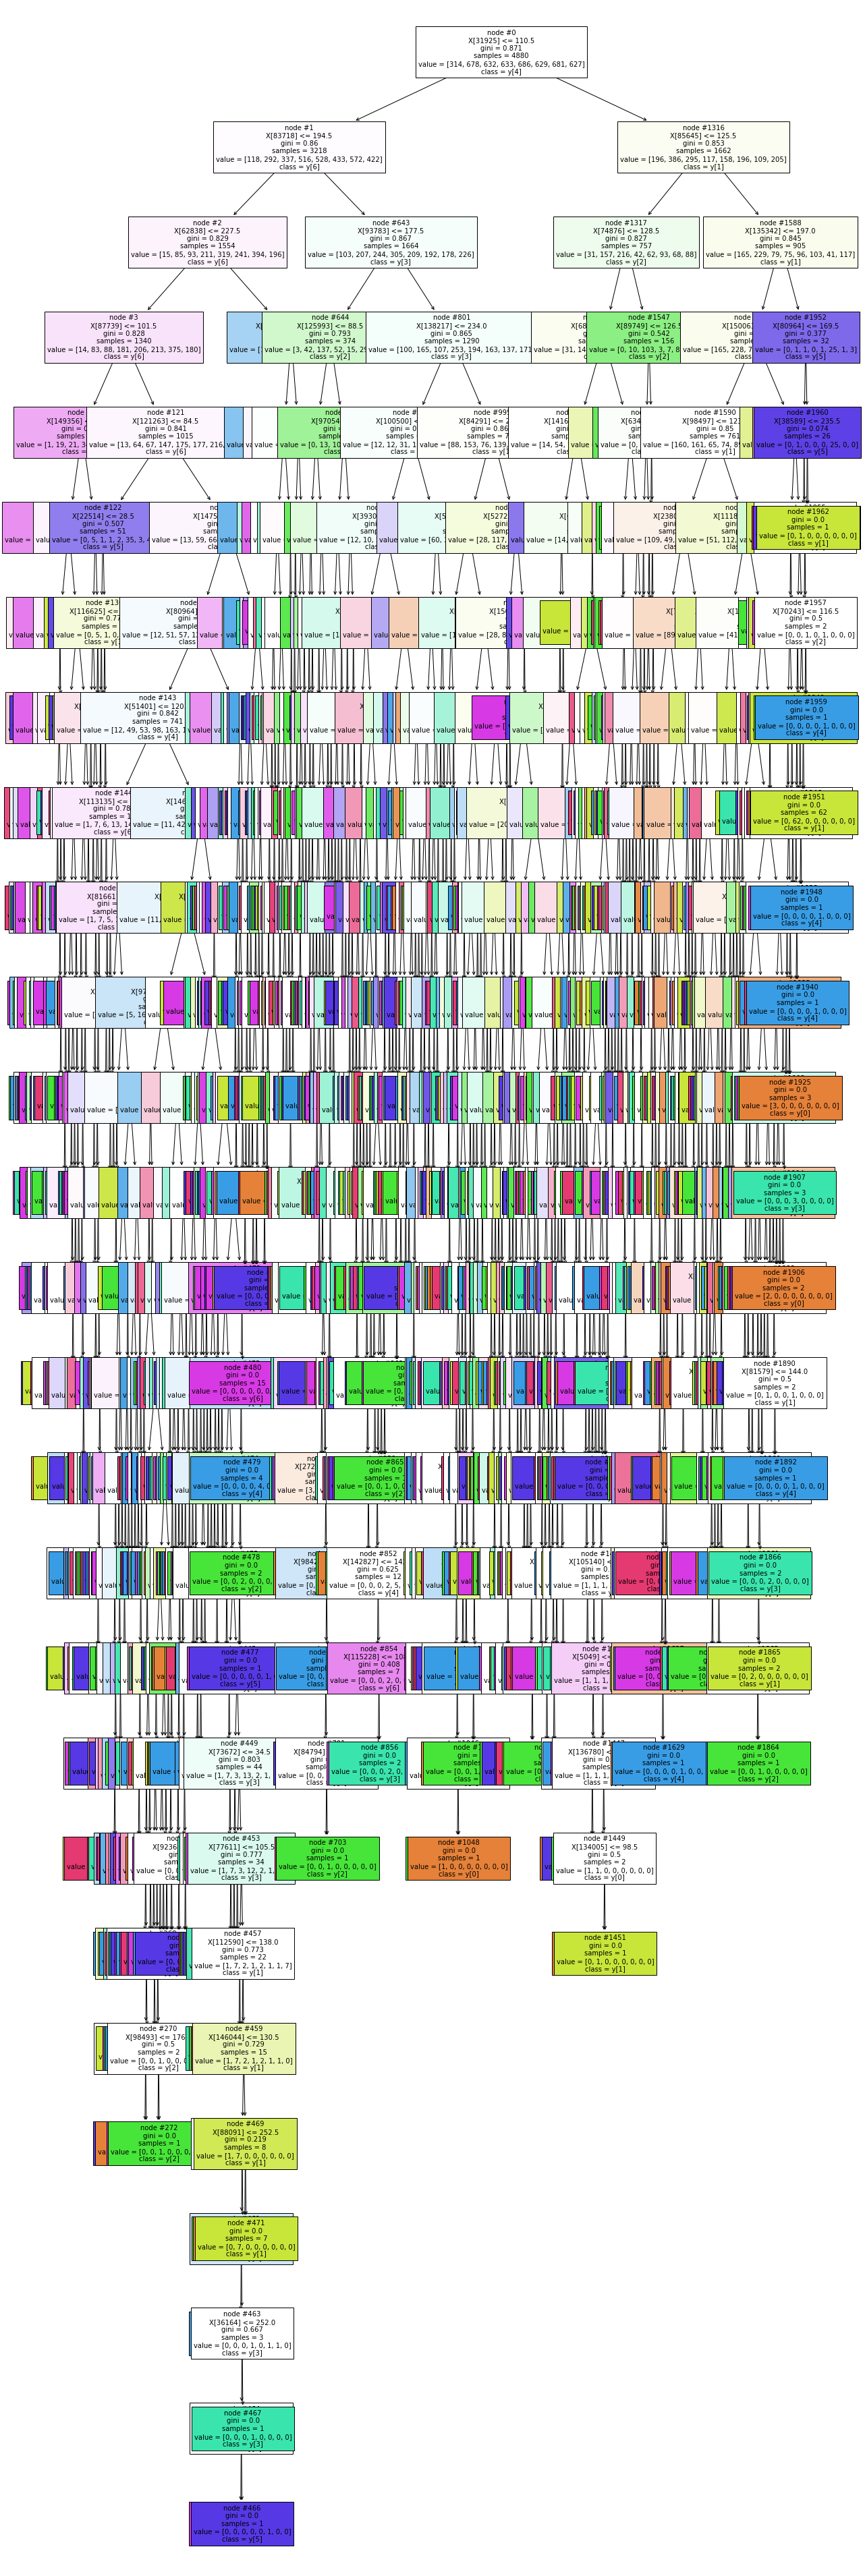

In [12]:
# Print Decision Tree
plt.figure(figsize=(20,70))
tree.plot_tree(DTC,filled=True,fontsize=10,node_ids=True,class_names=True)
plt.show()

## 4.4 Decision Tree with Bagging Classifier

Test Accuracy  0.1721311475409836
Train Accuracy  0.22971311475409836
              precision    recall  f1-score   support

           1       0.26      0.07      0.11        73
           2       0.25      0.25      0.25       152
           3       0.16      0.17      0.16       163
           4       0.15      0.21      0.18       165
           5       0.16      0.19      0.17       167
           6       0.15      0.15      0.15       165
           7       0.22      0.19      0.20       186
           8       0.11      0.09      0.10       149

    accuracy                           0.17      1220
   macro avg       0.18      0.16      0.17      1220
weighted avg       0.18      0.17      0.17      1220



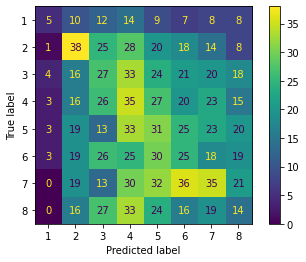

In [16]:
dec_tree = tree.DecisionTreeClassifier(criterion="entropy",max_features="auto")
bagging = BaggingClassifier(base_estimator=dec_tree, 
                            n_estimators=20,
                            max_features=5,
                            max_samples=100,
                            random_state=1, 
                            n_jobs=5)
bagging.fit(data1_train,target1_train)
predictionTest = bagging.predict(data1_test)
predictionTrain = bagging.predict(data1_train)
print("Test Accuracy ",accuracy_score(target1_test,predictionTest))
print("Train Accuracy ",accuracy_score(target1_train,predictionTrain))
print(classification_report(target1_test,predictionTest))
plot_confusion_matrix(bagging,data1_test,target1_test)
acc_train.append(accuracy_score(target1_train,predictionTrain))
acc_test.append(accuracy_score(target1_test,predictionTest))

## 4.5 Random Forrest Classifier

Test Accuracy  0.7418032786885246
Train Accuracy  1.0
              precision    recall  f1-score   support

           1       0.86      0.86      0.86        73
           2       0.73      0.86      0.79       152
           3       0.76      0.72      0.74       163
           4       0.66      0.73      0.70       165
           5       0.71      0.72      0.72       167
           6       0.77      0.64      0.70       165
           7       0.80      0.74      0.77       186
           8       0.72      0.74      0.73       149

    accuracy                           0.74      1220
   macro avg       0.75      0.75      0.75      1220
weighted avg       0.75      0.74      0.74      1220



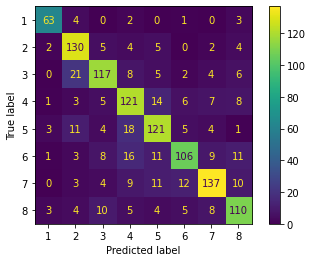

In [17]:
rfc = RandomForestClassifier().fit(data1_train,target1_train)
predictionTest = rfc.predict(data1_test)
predictionTrain = rfc.predict(data1_train)
print("Test Accuracy ",accuracy_score(target1_test,predictionTest))
print("Train Accuracy ",accuracy_score(target1_train,predictionTrain))
print(classification_report(target1_test,predictionTest))
plot_confusion_matrix(rfc,data1_test,target1_test)
acc_train.append(accuracy_score(target1_train,predictionTrain))
acc_test.append(accuracy_score(target1_test,predictionTest))

## 4.6 KNN

In [18]:
knn_model = KMeans(n_clusters = 4).fit(data1_train)
predictionTest = knn_model.predict(data1_test)
predictionTrain = knn_model.predict(data1_train)
print("Test Accuracy ",accuracy_score(target1_test,predictionTest))
print("Train Accuracy ",accuracy_score(target1_train,predictionTrain))
print(classification_report(target1_test,predictionTest))
acc_train.append(accuracy_score(target1_train,predictionTrain))
acc_test.append(accuracy_score(target1_test,predictionTest))

Test Accuracy  0.0942622950819672
Train Accuracy  0.10061475409836065
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.05      0.27      0.08        73
           2       0.11      0.26      0.16       152
           3       0.14      0.34      0.20       163
           4       0.00      0.00      0.00       165
           5       0.00      0.00      0.00       167
           6       0.00      0.00      0.00       165
           7       0.00      0.00      0.00       186
           8       0.00      0.00      0.00       149

    accuracy                           0.09      1220
   macro avg       0.03      0.10      0.05      1220
weighted avg       0.04      0.09      0.05      1220



# 5. Final Results

In [20]:
rnn = "RNN with "+ best_optim + " optimizer"
final_result = pd.DataFrame({'Model':[rnn,'Bayes classifier with default parameters','Decision Tree Classifier',
                                      'Decision Tree with Bagging Classifier', 'Random Forest with deafult parameters',
                                      'KNN Model with 4 clusters'], 'Train_Accuracy': acc_train,'Test_Accuracy': acc_test})

final_result

,Model,Train_Accuracy,Test_Accuracy
0,RNN with rmsprop optimizer,0.480533,0.465574
1,Bayes classifier with default parameters,0.200615,0.171311
2,Decision Tree Classifier,1.000000,0.390984
3,Decision Tree with Bagging Classifier,0.229713,0.172131
4,Random Forest with deafult parameters,1.000000,0.741803
5,KNN Model with 4 clusters,0.100615,0.094262
